# Detection Pipeline 
    starting point- https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image


In [2]:
%matplotlib inline

In [3]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util
#generates big matplotlib warning

/home/amol/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/amol/anaconda3/envs/self-drive/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/amol/anaconda3/envs/self-drive/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/amol/anaconda3/envs/self-drive/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/amol/anaconda3/envs/self-drive/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/amol/anaconda3/envs/self-drive/li

In [4]:
MODEL_NAME = 'ssd_inception_v2_coco_2018_01_28'


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/home/amol/frozen_models/ssd_simulator/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/home/amol/ObjectDetection/SimulatorData', 'label_map.pbtxt')

In [6]:
MODEL_NAME = 'rfcn_resnet101_coco_2018_01_28'


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/home/amol/frozen_models/rfcn_resnet/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/home/amol/ObjectDetection/data', 'label_map.pbtxt')

# Load a (frozen) Tensorflow model into memory

In [13]:
type(category_index)

dict

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
#NUM_CLASSES=14
NUM_CLASSES = 3
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [10]:
#PATH_TO_TEST_IMAGES_DIR = '/home/amol/TrafficLightImages/test/rgb/test'
PATH_TO_TEST_IMAGES_DIR ='/home/amol/Downloads/sim_data/data/sim_training_data/sim_data_capture'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.png'.format(i)) for i in [24068,24124,24312,24464,24654,25160] ]
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in ['left0003','left0011','left0537'] ]
# Size, in inches, of the output images.
IMAGE_SIZE = (10, 10)

In [11]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

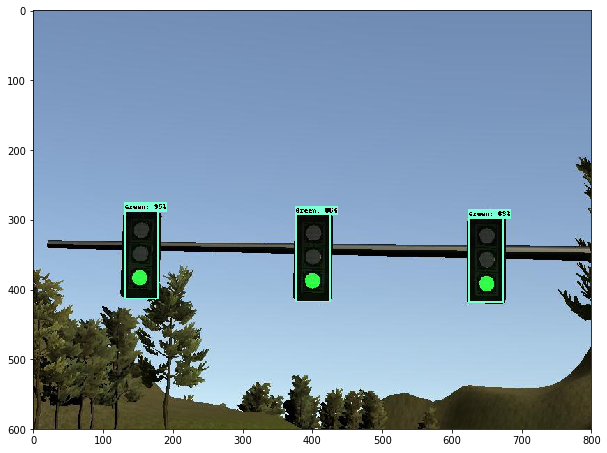

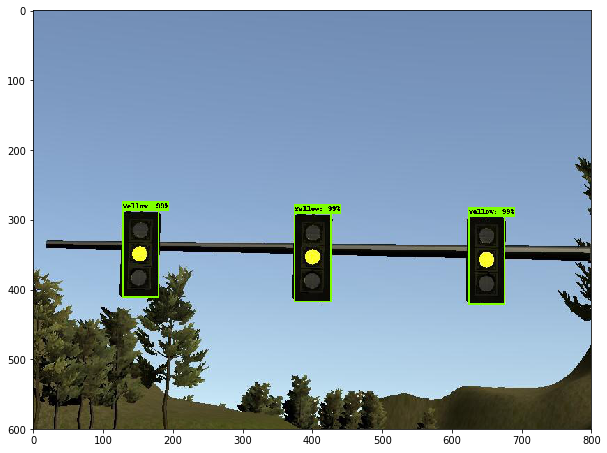

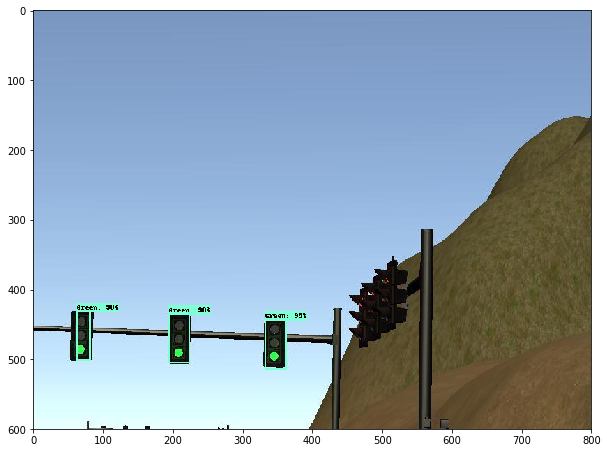

In [12]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=2)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)